In [13]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import rc_context
import bbknn
import re
import json
import os
import rpy2
import anndata
from datetime import date
from scipy.stats import binom_test
from datetime import datetime

# YYYY-MM-DD
today = date.today()
today = today.strftime("%Y-%m-%d")

import warnings
warnings.filterwarnings('ignore')

# Set up

In [14]:
# Check the threshold for binarisation, the ouput is specific to that
threshold=0.1
threshold_for_filename=str(threshold).replace('.','p')
print(threshold_for_filename)

# Confirm the output path
output_path='/nfs/team205/heart/EBI_GWAS/enrichment_testing_output_proportion_of_SNPs/'

0p1


# Read in output file

In [15]:
combined_output_df=pd.read_csv(f'{output_path}{threshold_for_filename}_all_traits_summary.csv',index_col='cell_type')
combined_output_df['efo_term']=combined_output_df['efo_term'].astype(str)+"_"+combined_output_df['n_SNPs'].astype(str) # Add the n_SNPs - useful for later inspection
combined_output_df

,proportion_of_all_open_peaks_found_in_this_celltype,proportion_of_SNPs_found_in_celltype_specific_open_peaks,mean_proportions_of_SNPs_in_open_peaks,p_value,n_SNPs,efo_id,efo_term
cell_type,,,,,,,
MyocardialInterstitialFibroblasts,0.029137,0.083333,0.030517,0.330,46,EFO_0004644,TPE interval measurement_46
CoronaryEndothelialCellsArterial,0.039600,0.083333,0.034919,0.731,46,EFO_0004644,TPE interval measurement_46
MyocardialInterstitialFibroblasts,0.029137,0.058824,0.028451,0.078,633,EFO_0004761,uric acid measurement_633
CoronaryEndothelialCellsArterial,0.039600,0.049020,0.033698,0.882,633,EFO_0004761,uric acid measurement_633


<AxesSubplot:>

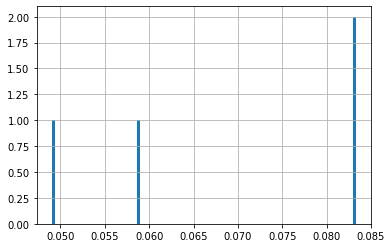

In [16]:
combined_output_df.proportion_of_SNPs_found_in_celltype_specific_open_peaks.hist(bins=100)

In [17]:
#pivot the table to prepare for heatmap
df=combined_output_df[['p_value','efo_term']]
df=df.pivot_table(values='p_value',index='cell_type',columns='efo_term')
df.head()

efo_term,TPE interval measurement_46,uric acid measurement_633
cell_type,,
CoronaryEndothelialCellsArterial,0.731,0.882
MyocardialInterstitialFibroblasts,0.330,0.078


In [18]:
# multiple testing correction
import statsmodels.stats.multitest
from statsmodels.stats.multitest import multipletests

method='bonferroni'
columns=df.columns.tolist()

# correct for multiple testing (each test being one cell type)
for column in columns:
    df[column]=statsmodels.stats.multitest.multipletests(df[column],method=method)[1]
df.head()

efo_term,TPE interval measurement_46,uric acid measurement_633
cell_type,,
CoronaryEndothelialCellsArterial,1.00,1.000
MyocardialInterstitialFibroblasts,0.66,0.156


efo_term,TPE interval measurement_46,uric acid measurement_633
cell_type,,
CoronaryEndothelialCellsArterial,0.000000,0.000000
MyocardialInterstitialFibroblasts,0.180456,0.806875


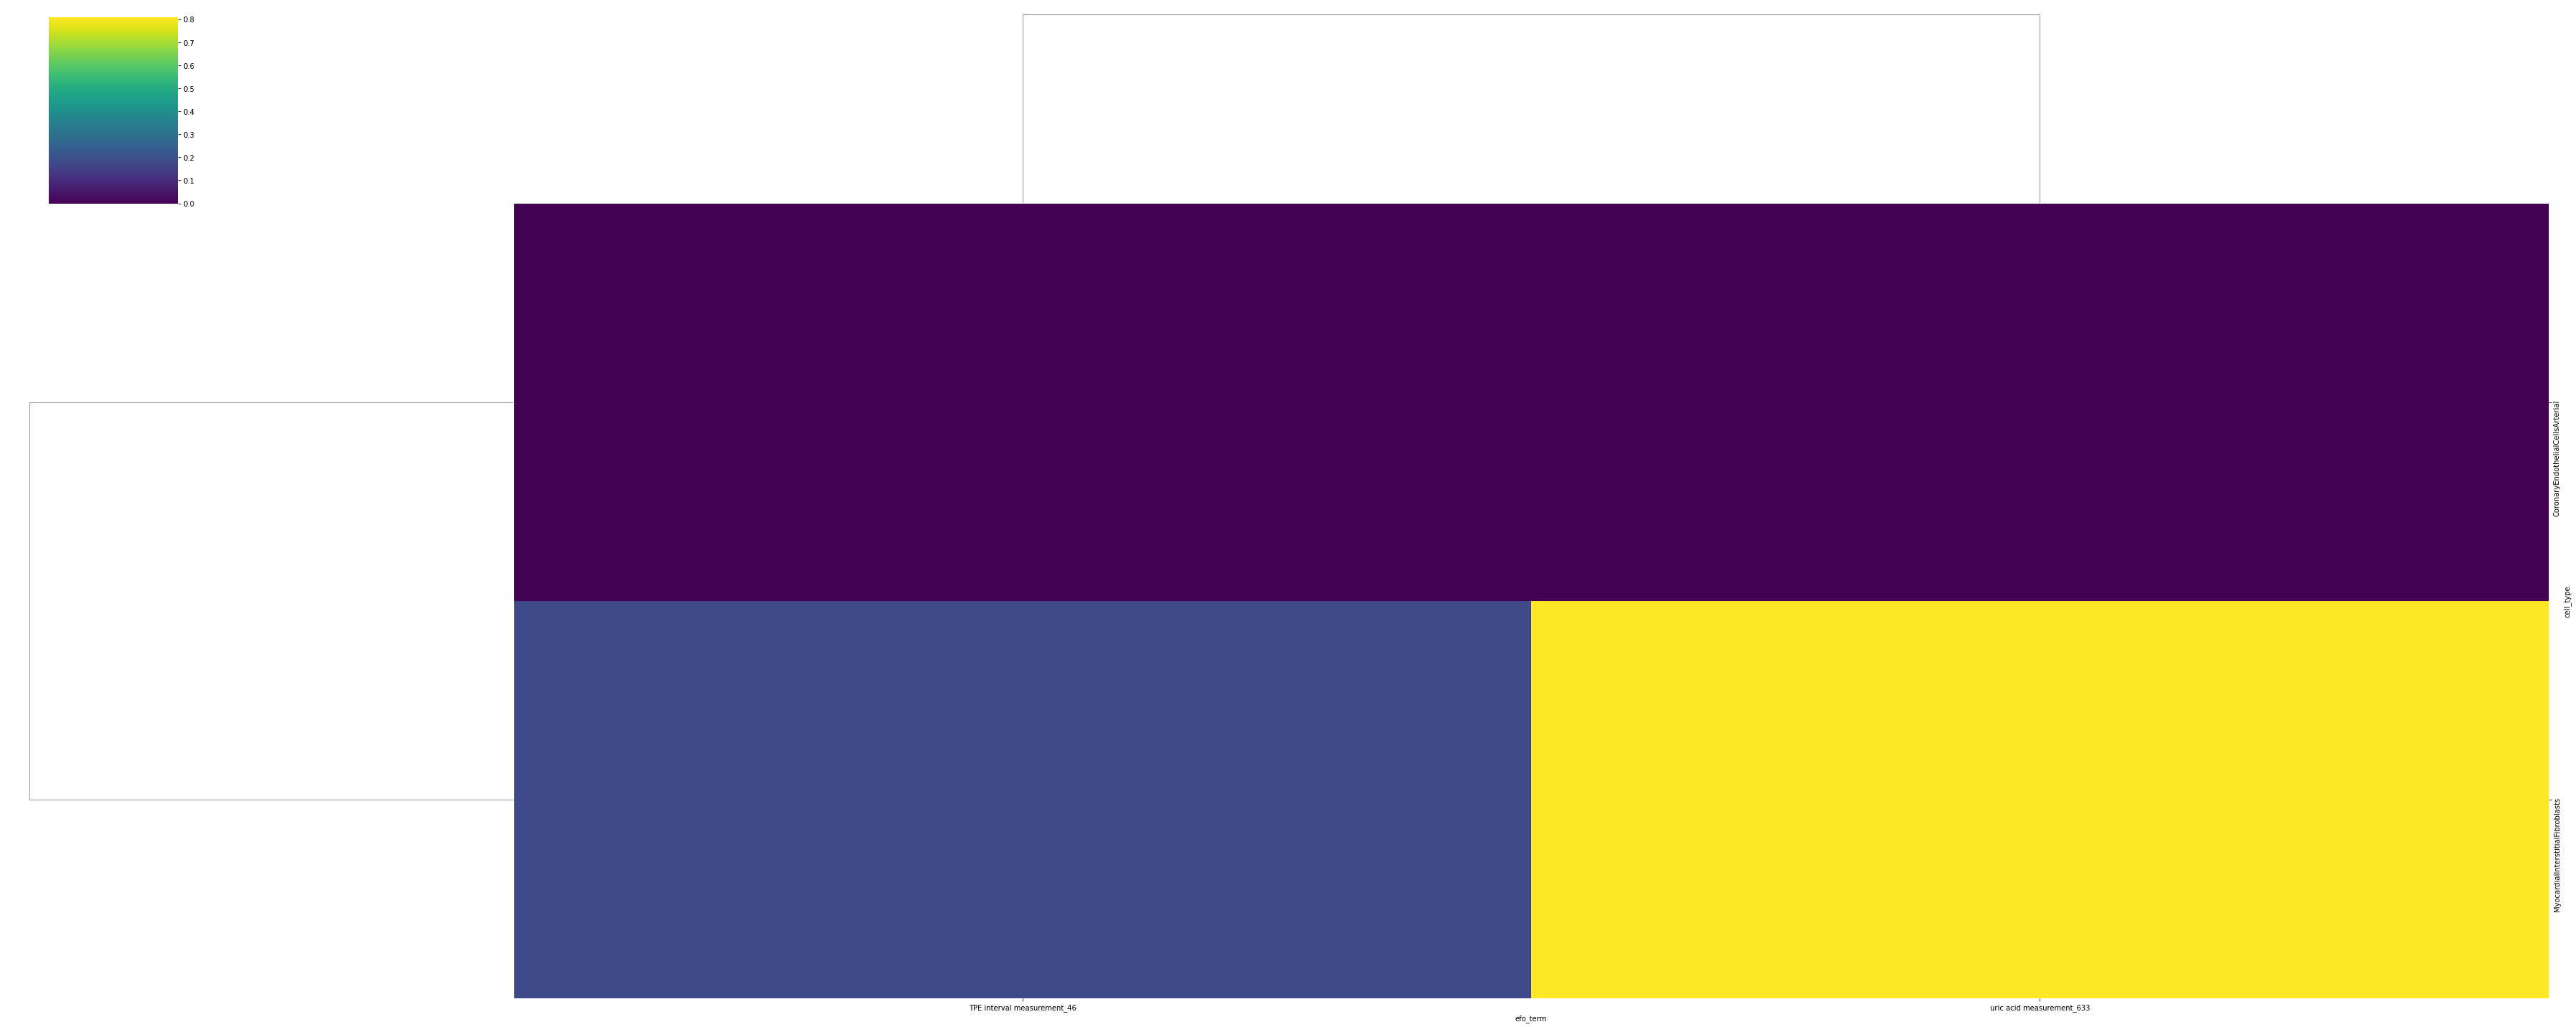

In [19]:
# log-neg transform, then plot

df=np.negative(np.log10(df))
df[df == -0] = 0 # replace '-0' with '0'
df.replace(to_replace=[np.inf, -np.inf], value='inf', inplace=True) # replace infinities with something sensible (the maximum real number found elsewhere in the df)
df.replace(to_replace='inf', value=df.max().max(), inplace=True)

sns.clustermap(df,xticklabels=True,yticklabels=True,cmap='viridis',figsize=(50,20))

df.head()

efo_term,TPE interval measurement_46,uric acid measurement_633
cell_type,,
CoronaryEndothelialCellsArterial,0.000000,0.000000
MyocardialInterstitialFibroblasts,0.180456,0.806875


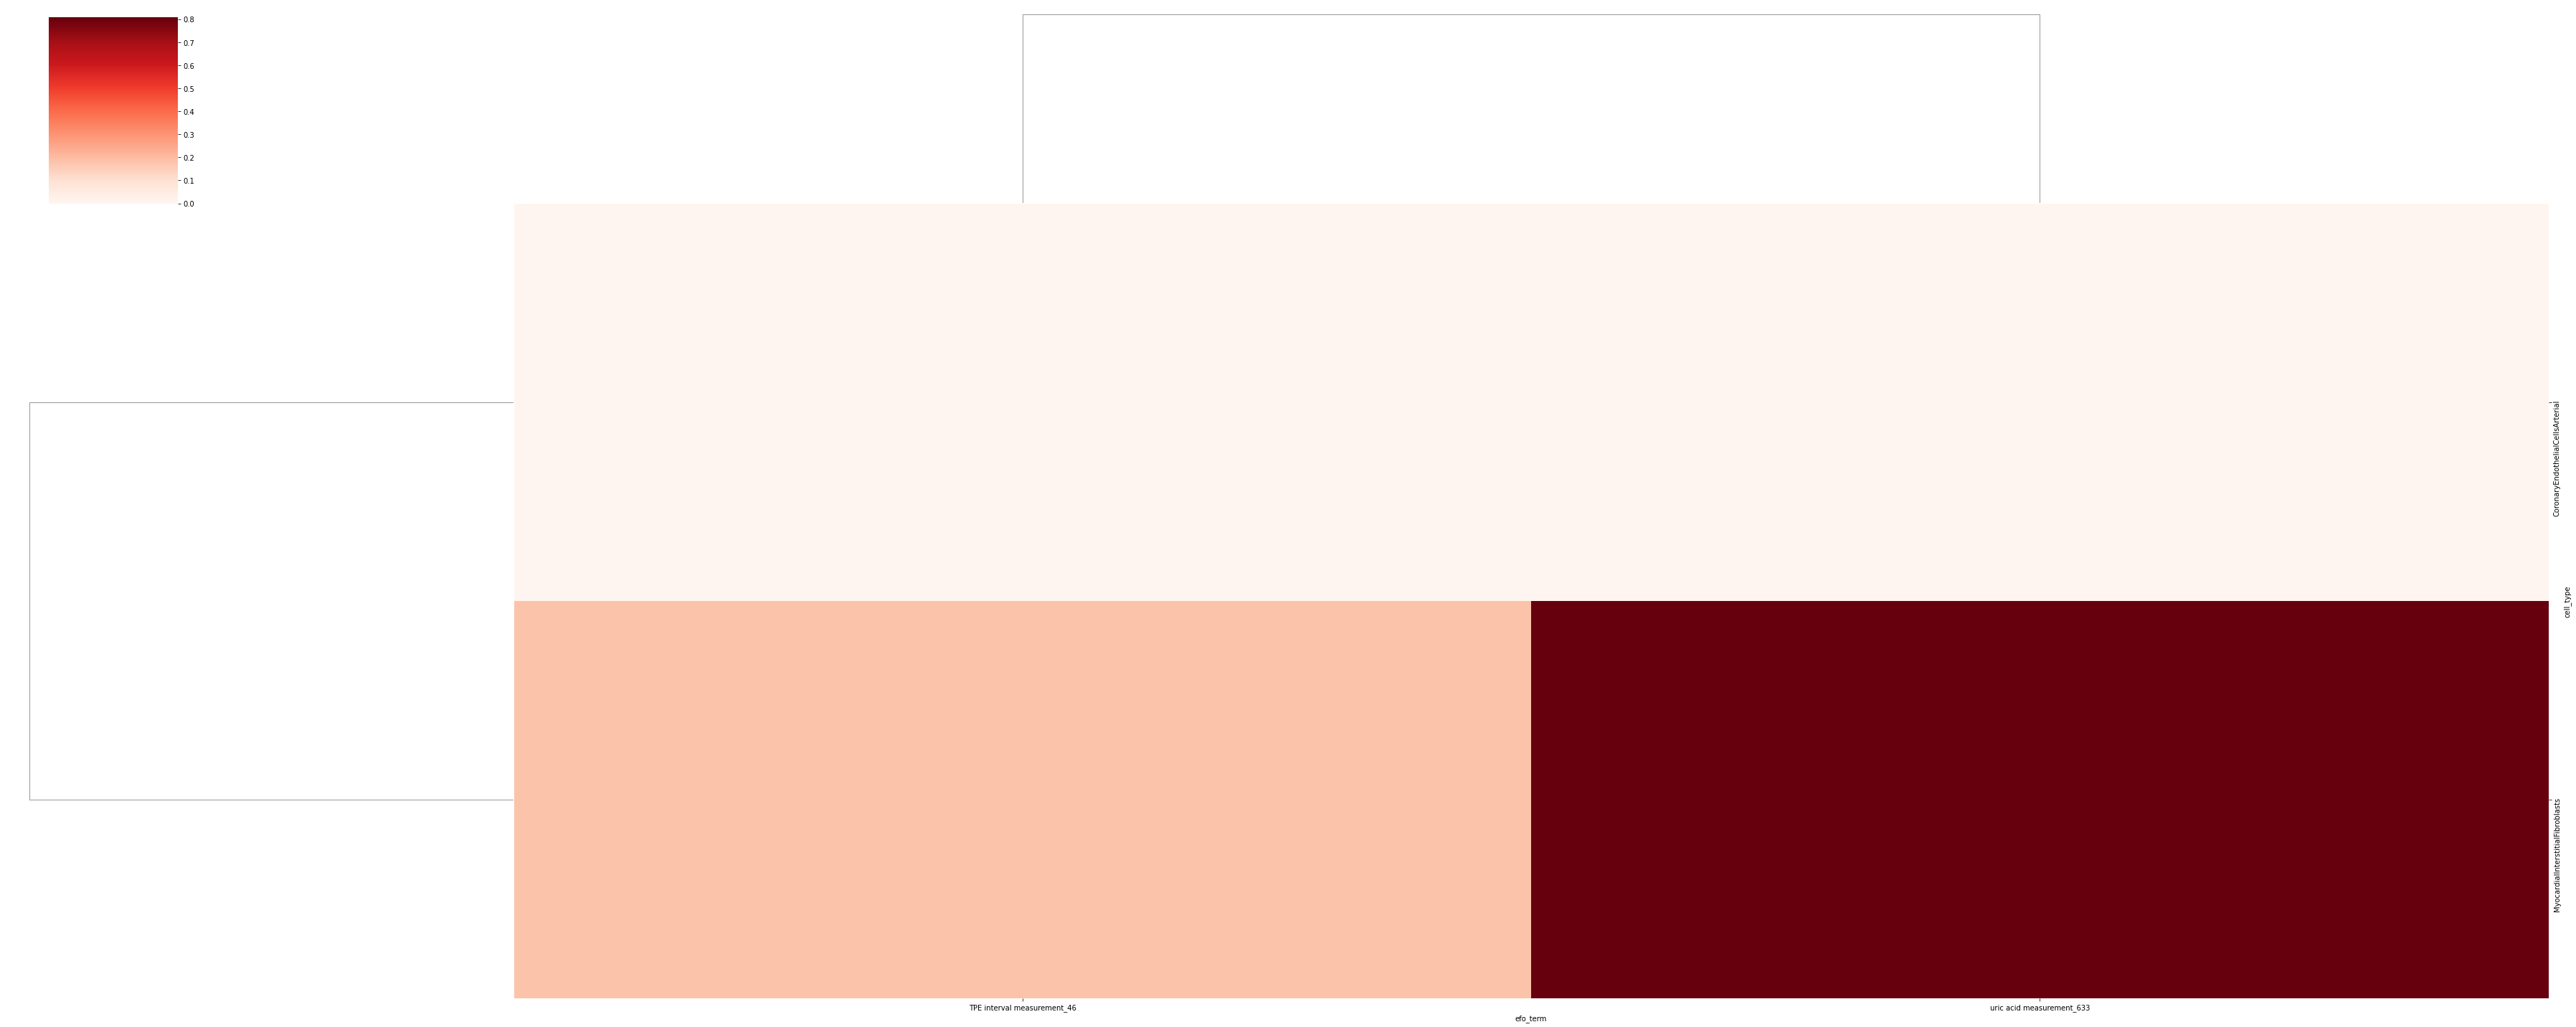

In [20]:
# remove any columns (traits) where all log-neg pvalues are 0
df = df.loc[:, (df != 0).any(axis=0)]

sns.clustermap(df,xticklabels=True,yticklabels=True,cmap='Reds',figsize=(50,20))

df.head()

In [21]:
traits_to_keep=[
'Brugada syndrome_26','Mitral valve prolapse_36', 'PR interval_467','QRS amplitude_44', 'QRS complex_73',
       'QRS duration_327', 'QT interval_592', 'RR interval_31',
       'T wave morphology measurement_13','aortic measurement_285', 'aortic root size_21',
       'aortic stenosis_32', 'aortic valve calcification_27', 'ascending aortic diameter_110',
       'atrial fibrillation_473',
       'congenital left-sided heart lesions_31',
       'coronary artery disease_1907',
       'dilated cardiomyopathy_16',
#    'ejection fraction measurement_28',
#       'electrocardiography_464',
#    'essential hypertension_34',
    'heart failure_87', 'heart rate response to exercise_40',
       'heart rate response to recovery post exercise_65',
       'heart rate variability measurement_61', 'heart rate_301', 'hypertension_414',
       'hypertrophic cardiomyopathy_73',
       'left ventricular diastolic function measurement_33',
#       'left ventricular ejection fraction measurement_26',
       'left ventricular systolic function measurement_25',
       'myocardial infarction_346',
       'osteoarthritis_123', 'pulmonary embolism_13',
    #   'pulse pressure measurement_1706',
    'resting heart rate_128',
       'right ventricular ejection fraction measurement_14','sick sinus syndrome_6',
       'thoracic aortic aneurysm_28'
]


pruned_df=df.filter(items=traits_to_keep).drop(['AtrialCardiomyocytesCycling','VentricularCardiomyocytesCycling'])

pruned_df_anno=pruned_df
pruned_df_anno=pruned_df_anno.where(pruned_df_anno<1.2, other="***")
pruned_df_anno=pruned_df_anno.where(pruned_df_anno=='***', other=" ")
pruned_df_anno=pruned_df_anno.astype(str)


g=sns.clustermap(pruned_df,
               xticklabels=True,
               yticklabels=True,
               cmap='viridis',
               figsize=(20,20),
               annot=pruned_df_anno,
               fmt = '',
               dendrogram_ratio=0.05,
               cbar_pos=(0.98,0.9,0.02,0.1),
              )

g.ax_col_dendrogram.set_title(f'Enrichment of cell type-specific open chromatin for GWAS trait SNPs.\nScale = -log(p), "***" = p<0.05 (-log(p)>1.3), "open threshold" = {threshold}')
ax = g.ax_heatmap
ax.set_xlabel('GWAS traits')
ax.set_ylabel('Cell types')
plt.savefig(f'{output_path}_overview_heatmap_{threshold_for_filename}_SNP_enrichment.png')
plt.show()

KeyError: "['AtrialCardiomyocytesCycling', 'VentricularCardiomyocytesCycling'] not found in axis"

In [18]:
df_for_plotting=pruned_df_corrected
g=sns.clustermap(pruned_df,
               xticklabels=True,
               yticklabels=True,
               cmap='viridis',
               figsize=(20,20),
               annot=pruned_df_anno,
               fmt = '',
               dendrogram_ratio=0.05,
               cbar_pos=(0.98,0.9,0.02,0.1),
              )

g.ax_col_dendrogram.set_title(f'Enrichment of cell type-specific open chromatin for GWAS trait SNPs.\nScale = -log(p), "***" = p<0.05 (-log(p)>1.3), "open threshold" = {threshold}')
ax = g.ax_heatmap
ax.set_xlabel('GWAS traits')
ax.set_ylabel('Cell types')
plt.savefig(f'{output_path}_overview_heatmap_{threshold_for_filename}_SNP_enrichment.png')
plt.show()

NameError: name 'pruned_df_corrected' is not defined